
# Audio Resampling

**Author**: [Caroline Chen](carolinechen@meta.com)_, [Moto Hira](moto@meta.com)_

This tutorial shows how to use torchaudio's resampling API.


In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.1.2
2.1.2


## Preparation

First, we import the modules and define the helper functions.




In [2]:
import math
import timeit

import librosa
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import resampy
from IPython.display import Audio

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    times, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                times.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    times.append(t_max)
    freq.append(f_max)
    return times, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)

## Resampling Overview

To resample an audio waveform from one freqeuncy to another, you can use
- class `torchaudio.transforms.Resample` or
- function `torchaudio.functional.resample()`.





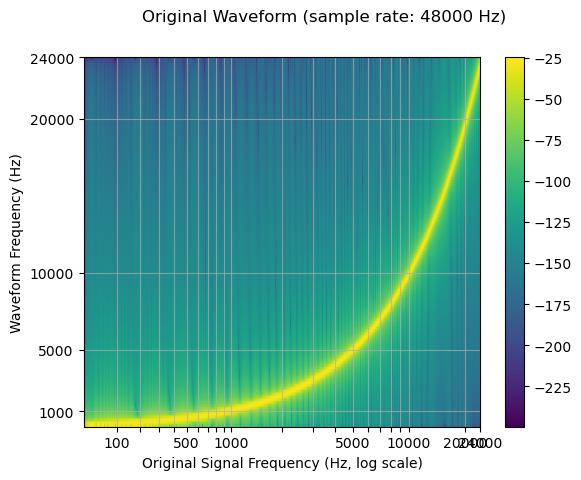

In [3]:
sample_rate = 48000
waveform = get_sine_sweep(sample_rate)

plot_sweep(waveform, sample_rate, title="Original Waveform")
Audio(waveform.numpy()[0], rate=sample_rate)

## 1. class `torchaudio.transforms.Resample` 

tensor([[ 0.0000e+00,  2.6263e-06,  7.8790e-06,  ..., -9.6075e-01,
          9.6067e-01, -9.6067e-01]], dtype=torch.float64)
tensor([[ 1.5281e-07,  4.9164e-06,  1.5829e-05,  ..., -2.6650e-02,
          5.5609e-02, -1.1814e-01]], dtype=torch.float64)


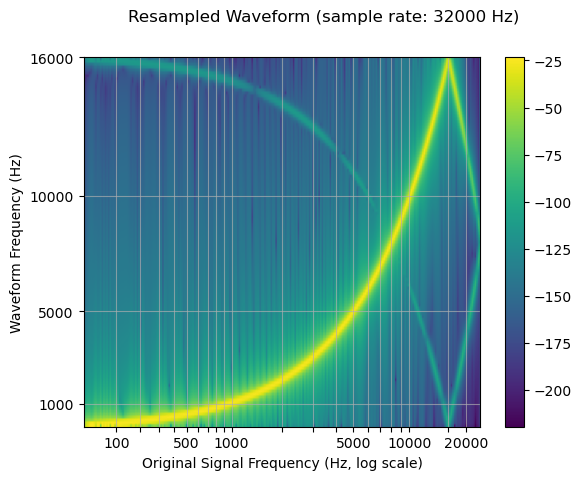

In [4]:
resample_rate = 32000

# Step 1 : Create an object of an resample class with some properties of old sr, new sr, 

resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)

# Step 2 : Pass the Tensor to this object . This will create resampled tensor

resampled_waveform = resampler(waveform)

plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)
print(waveform)
print(resampled_waveform)

## `2 : torchaudio.functional.resample()`

**Purpose:** This function resamples audio data saved as a tensor.

**Input:** 

- `Tensor`: Data to be resampled
- `Sample Rate` : The sample rate of the audio file
- `New Sample Rate` : The new sample rate of the audio file

**Output:** 

- `Tensor` : Returns a tensor with the resampled data

## Controling resampling quality with parameters

### Lowpass filter width

Because the filter used for interpolation extends infinitely, the
``lowpass_filter_width`` parameter is used to control for the width of
the filter to use to window the interpolation. It is also referred to as
the number of zero crossings, since the interpolation passes through
zero at every time unit. Using a larger ``lowpass_filter_width``
provides a sharper, more precise filter, but is more computationally
expensive.




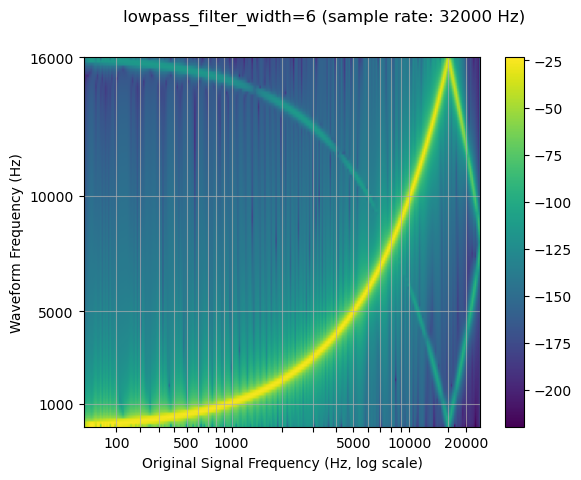

In [47]:
# Define new and old resample rate.
sample_rate = 48000
resample_rate = 32000
# Step 1 :  Pass input and get resampled tensor
resampled_waveform = F.resample(
                        waveform, 
                        sample_rate, 
                        resample_rate, 
                        lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

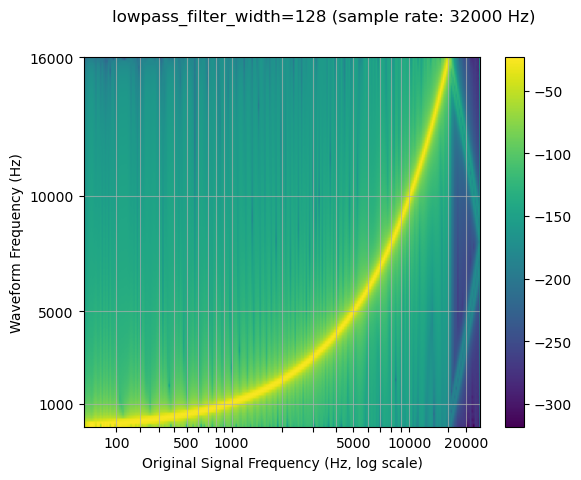

In [6]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

### Rolloff

The ``rolloff`` parameter is represented as a fraction of the Nyquist
frequency, which is the maximal frequency representable by a given
finite sample rate. ``rolloff`` determines the lowpass filter cutoff and
controls the degree of aliasing, which takes place when frequencies
higher than the Nyquist are mapped to lower frequencies. A lower rolloff
will therefore reduce the amount of aliasing, but it will also reduce
some of the higher frequencies.




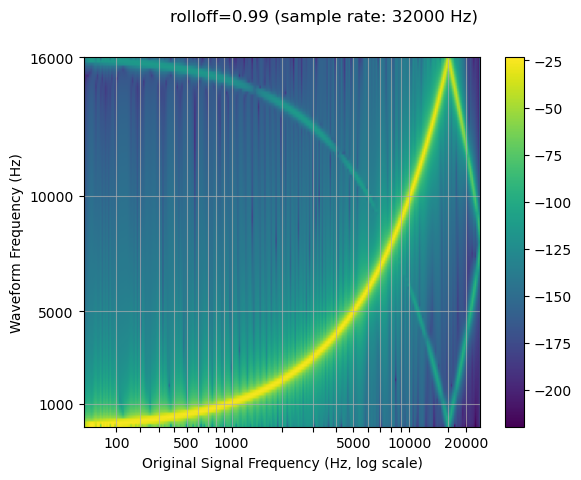

In [7]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

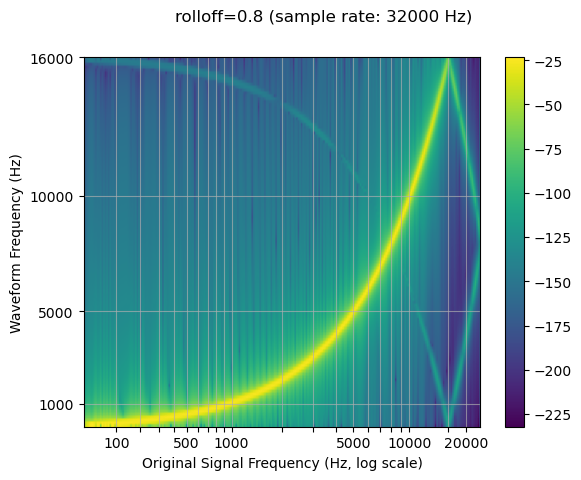

In [8]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

### Window function

By default, ``torchaudio``’s resample uses the Hann window filter, which is
a weighted cosine function. It additionally supports the Kaiser window,
which is a near optimal window function that contains an additional
``beta`` parameter that allows for the design of the smoothness of the
filter and width of impulse. This can be controlled using the
``resampling_method`` parameter.




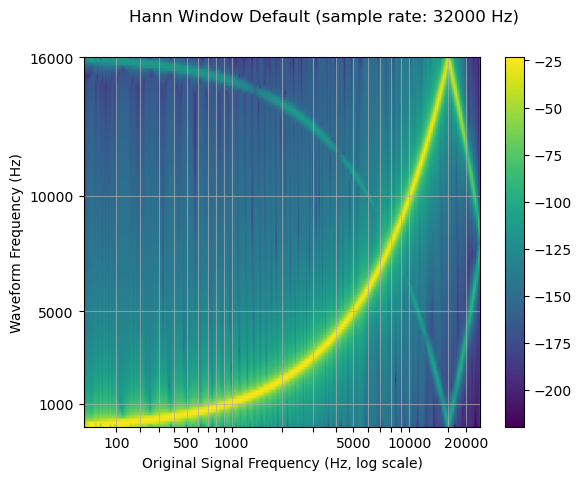

In [9]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interp_hann")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

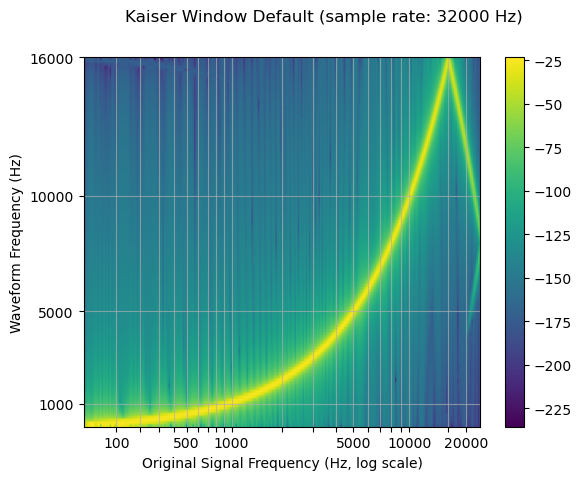

In [10]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interp_kaiser")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

## Comparison against librosa

``torchaudio``’s resample function can be used to produce results similar to
that of librosa (resampy)’s kaiser window resampling, with some noise




In [29]:
sample_rate = 48000
resample_rate = 32000

### kaiser_best




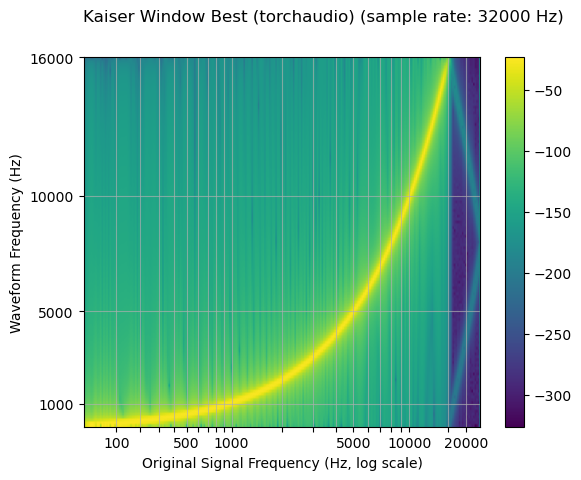

In [30]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="sinc_interp_kaiser",
    beta=14.769656459379492,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Best (torchaudio)")

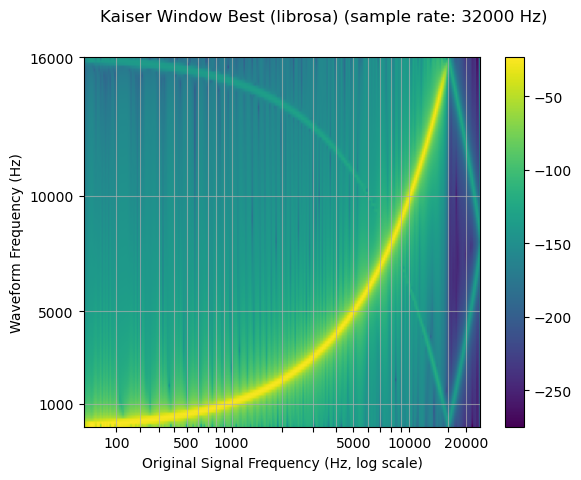

In [31]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), orig_sr=sample_rate, target_sr=resample_rate, res_type="kaiser_best")
).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Best (librosa)")

In [32]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser best MSE:", mse)

torchaudio and librosa kaiser best MSE: 0.0013004566355607605


### kaiser_fast




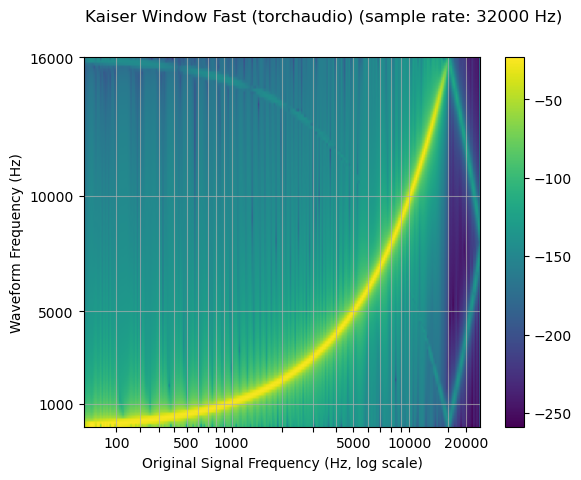

In [33]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=16,
    rolloff=0.85,
    resampling_method="sinc_interp_kaiser",
    beta=8.555504641634386,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Fast (torchaudio)")